In [79]:
import pandas as pd 
import numpy as np
import torch

In [80]:
protein_sequences_labelled = pd.read_csv("protein_sequences_labelled.csv")

In [81]:
protein_sequences_labelled

,structureId,concatenated_sequence,classification
0,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
1,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,HYDROLASE(O-GLYCOSYL)
2,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
3,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,HYDROLASE(O-GLYCOSYL)
4,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,OXYGEN TRANSPORT
...,...,...,...
127787,9RSA,KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTF...,HYDROLASE (PHOSPHORIC DIESTER)
127788,9RUB,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...,LYASE(CARBON-CARBON)
127789,9WGA,ERCGEQGSNMECPNNLCCSQYGYCGMGGDYCGKGCQNGACWTSKRC...,LECTIN (AGGLUTININ)
127790,9XIA,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...,ISOMERASE(INTRAMOLECULAR OXIDOREDUCTASE)


In [82]:
protein_seq_by_type = protein_sequences_labelled.groupby('classification')['concatenated_sequence'].apply(list).to_dict()

In [83]:
all_sequences = ''.join(protein_sequences_labelled['concatenated_sequence'].values)
all_characters = list(set(all_sequences))
character_index = {char: all_characters.index(char) for char in all_characters}
n_characters = len(all_characters)
all_protein_classifications = protein_sequences_labelled['classification'].unique().tolist()
n_classifications = len(all_protein_classifications)

In [84]:
def AA_to_index(AA):
    return character_index[AA]

def AA_to_tensor(AA):
    tensor = torch.zeros(1, n_characters)
    tensor[0][AA_to_index(AA)] = 1
    return tensor

def polypeptide_to_tensor(polypeptide):
    tensor = torch.zeros(len(polypeptide), 1, n_characters)
    for index, AA in enumerate(polypeptide):
        tensor[index][0][AA_to_index(AA)] = 1
    return tensor

In [85]:
# print(AA_to_tensor('L'))
# print(polypeptide_to_tensor("SVQATREDKFSFGL+S").size())

In [96]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size).to(device)

n_hidden = 128
rnn = RNN(n_characters, n_hidden, n_classifications).to(device)

In [87]:
# input = lineToTensor('Albert')
# hidden = torch.zeros(1, n_hidden)

# output, next_hidden = rnn(input[0], hidden)
# print(output)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_protein_classifications[category_i], category_i

# print(categoryFromOutput(output))

In [98]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_protein_classifications)
    line = randomChoice(protein_seq_by_type[category])
    category_tensor = torch.tensor([all_protein_classifications.index(category)], dtype=torch.long).to(device)
    line_tensor = polypeptide_to_tensor(line).to(device)
    return category, line, category_tensor, line_tensor

# for i in range(10):
#     category, line, category_tensor, line_tensor = randomTrainingExample()
#     print('category =', category, '/ line =', line)

In [89]:
criterion = nn.NLLLoss()

In [99]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

import matplotlib.pyplot as plt

def train(dataloader, model, criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode
    all_losses = []  # To store the loss for each batch

    for epoch in range(num_epochs):
        total_loss = 0.0
        epoch_losses = []  # Track the loss for this epoch
        
        for line_tensor, category_tensor in dataloader:
            optimizer.zero_grad()

            # Move data to the appropriate device
            line_tensor = line_tensor.to(device)
            category_tensor = category_tensor.to(device)

            # Forward pass through the model
            output = model(line_tensor)
            
            # Compute loss
            loss = criterion(output, category_tensor)
            epoch_losses.append(loss.item())  # Save batch loss for this epoch
            
            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # After each epoch, store the average loss
        all_losses.append(sum(epoch_losses) / len(epoch_losses))
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {all_losses[-1]}")

    return all_losses  # Return all the epoch losses for plotting


In [100]:
import time
import math

n_iters = 10000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    # print(iter)
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 50% (23m 51s) 8.5238 LVPGEEWEFEVTAFYRGRQVFQQTISCPEGLRLVGSEVGDRTLPGWPVTLPDPGMSLTDRGVMSYVRHVLSCLGGGLALWRAGQWLWAQRLGHCHTYWAVSEELLPNSGHGPDGEVPKDKEGGVFDLGPFIVDLITFTEGSGRSPRYALWFCVGESWPQDQPWTKRLVMVKVVPTCLRALVEMARVGGASS+LVPGEEWEFEVTAFYRGRQVFQQTISCPEGLRLVGSEVGDRTLPGWPVTLPDPGMSLTDRGVMSYVRHVLSCLGGGLALWRAGQWLWAQRLGHCHTYWAVSEELLPNSGHGPDGEVPKDKEGGVFDLGPFIVDLITFTEGSGRSPRYALWFCVGESWPQDQPWTKRLVMVKVVPTCLRALVEMARVGGASS+SALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQRTAKYVAN+SALQDLLRTLKSPSSPQQQQQVLNILKSNPQLMAAFIKQRTAKYVAN / CELLULOSE BINDING PROTEIN ✗ (transcription/transferase)
10000 100% (46m 46s) 8.5232 MHHHHHHSSGRENLYFQGMSQKEQTLMTPYLQFNRHQWAALRDSVPMTLTEDEITRLKGINEDLSLEEVAEIYLPLSRLLNFYISSNLRRQAVLEQFLGTNGQRIPYIISIAGSVAVGKSTTARVLQALLSRWPEHRHVELITTDGFLHPNSVLKERGLMKKKGFPQSYDMHRLVKFVSDLKSGVPQATAPVYSHLIYDVIPDGDKTVAQPDILILEGLNVLQSGMDYPHDPHHVFVSDFVDFSIYVDAPEELLKSWYINRFLKFREGAFTDPDSYFHNYAKLSKEEAVDIATSLWNEINLMNLKENILPTRERASLIMTKSANHSVNQVRLRK+MHHHHHHSSGRENLYFQGMSQKEQTLMTPYLQFNRHQWAALRDSVPMTLTEDEITRLKGINEDLSLEEVAEIY

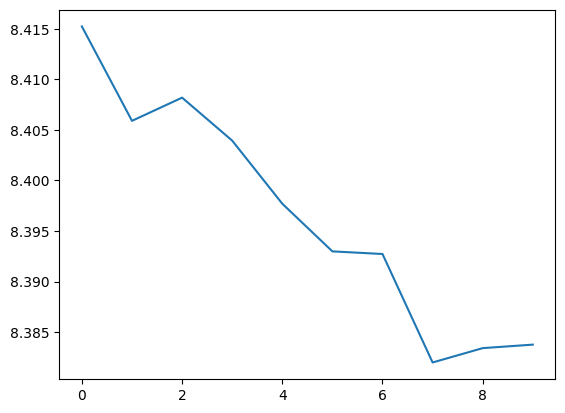

In [102]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_708/349641431.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_protein_classifications, rotation=90)
/tmp/ipykernel_708/349641431.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_protein_classifications)
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 4470 ticks ([-1.0, ..., 4468.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to gen

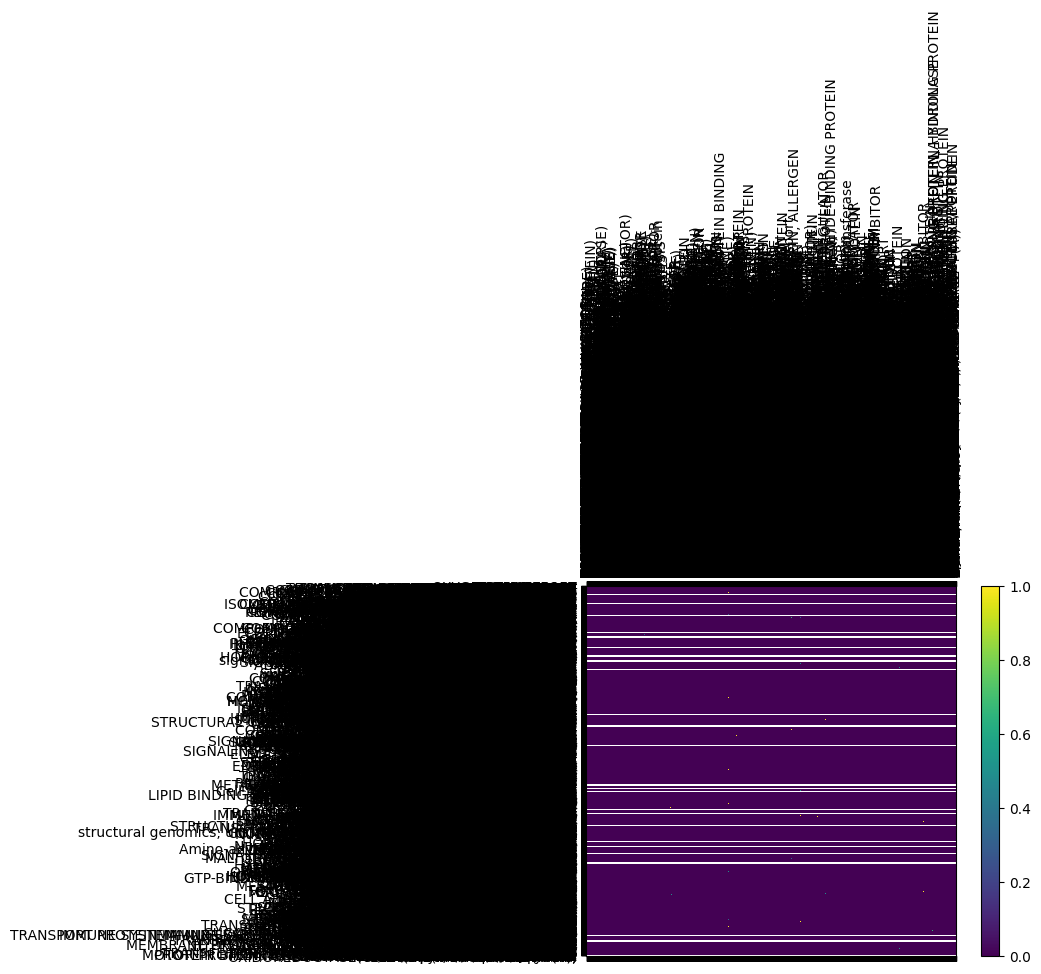

In [103]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_classifications, n_classifications)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_protein_classifications.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_classifications):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_protein_classifications, rotation=90)
ax.set_yticklabels([''] + all_protein_classifications)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()